# Mining Big Data: Assignment 2 - Group Project

## Group members:

1) Paridhi Awadheshpratap Singh | a1865487

2) Chahat Segan | a1855353

3) Ujjwal Bhardwaj | a1881450

### Improved Recommendation System from Frequent Patterns

### Data Loading

In [2]:
import random
from tabulate import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the data files
train_path = 'basket_data_by_date_train.csv'
test_path = 'basket_data_by_date_test.csv'
big_train_path = 'basket_data_by_date_train_big.csv'
big_test_path = 'basket_data_by_date_test_big.csv'

# Load the data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
big_train = pd.read_csv(big_train_path)
big_test = pd.read_csv(big_test_path)


Currently, we can verify if the values in both sets are unique. This allows us to prepare our system to search for items that may fall under a cold start item issue.

In [4]:
# Extract unique item names from each DataFrame
unique_items_df1 = set(train['Itemname'])
unique_items_df2 = set(test['Itemname'])

# Check if the unique item names are the same in both DataFrames
if unique_items_df1 == unique_items_df2:
    print("Unique item names are the same in both CSV files.")
else:
    print("Unique item names are not the same in both CSV files.")


Unique item names are not the same in both CSV files.


It is important to note that certain items within the test data set may not be included in our training data set. As a result, our recommender system may encounter a "cold start" issue when suggesting these items. We can confirm that we will need to address this during runtime.

### Exploratory Data Analysis

To understand the relationship between each of these variables we do some EDA. Before that we need to understand the nature of each variable and make the dataset suitable for further processing.


In [5]:
# Checking for missing values and statistical summaries
print(train.isnull().sum())
train.describe()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64


,BillNo,Quantity,Price,CustomerID,cost
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,540254.879225,3.487700,3.732165,15577.606525,11.097411
std,2380.444952,2.611766,5.711630,1730.347123,13.298301
min,536365.000000,1.000000,0.100000,12347.000000,0.140000
25%,538093.000000,1.000000,1.650000,14224.000000,3.300000
50%,540373.000000,2.000000,2.950000,15570.000000,7.950000
75%,542360.000000,6.000000,4.650000,17220.000000,15.800000
max,544398.000000,10.000000,295.000000,18283.000000,527.700000


In big data mining, sparsity refers to the condition where most data elements have missing or zero values, making analysis and modelling challenging. We can check the sparsity of our data with the help of the below code snippet.

In [6]:
# Calculate the total number of elements in the train dataset
total_elements = train.shape[0] * train.shape[1]

# Count the number of zero values in the train dataset
zero_values_count = (train == 0).sum().sum()

# Calculate the sparsity as the ratio of zero values to total elements
sparsity = zero_values_count / total_elements

print("Sparsity of the train data: {:.2%}".format(sparsity))


Sparsity of the train data: 0.00%


The output indicates a sparsity of 0.00%, which suggests that there are no zero values in the dataset, leading to the conclusion that the data is dense.

We can go ahead and drop the column 'BillNo' as it is completely unwanted in our analysis. We aim to group the data using customerId, therefore 'BillNo' holds no importance in this analysis and we can go ahead and drop it.

In [7]:
# Remove the 'bill number' column from the DataFrame
train = train.drop(columns=['BillNo'])
test = test.drop(columns=['BillNo'])

We can have a look at the best selling items and the sold number of pieces in our data set with the help of a graph plotted below:

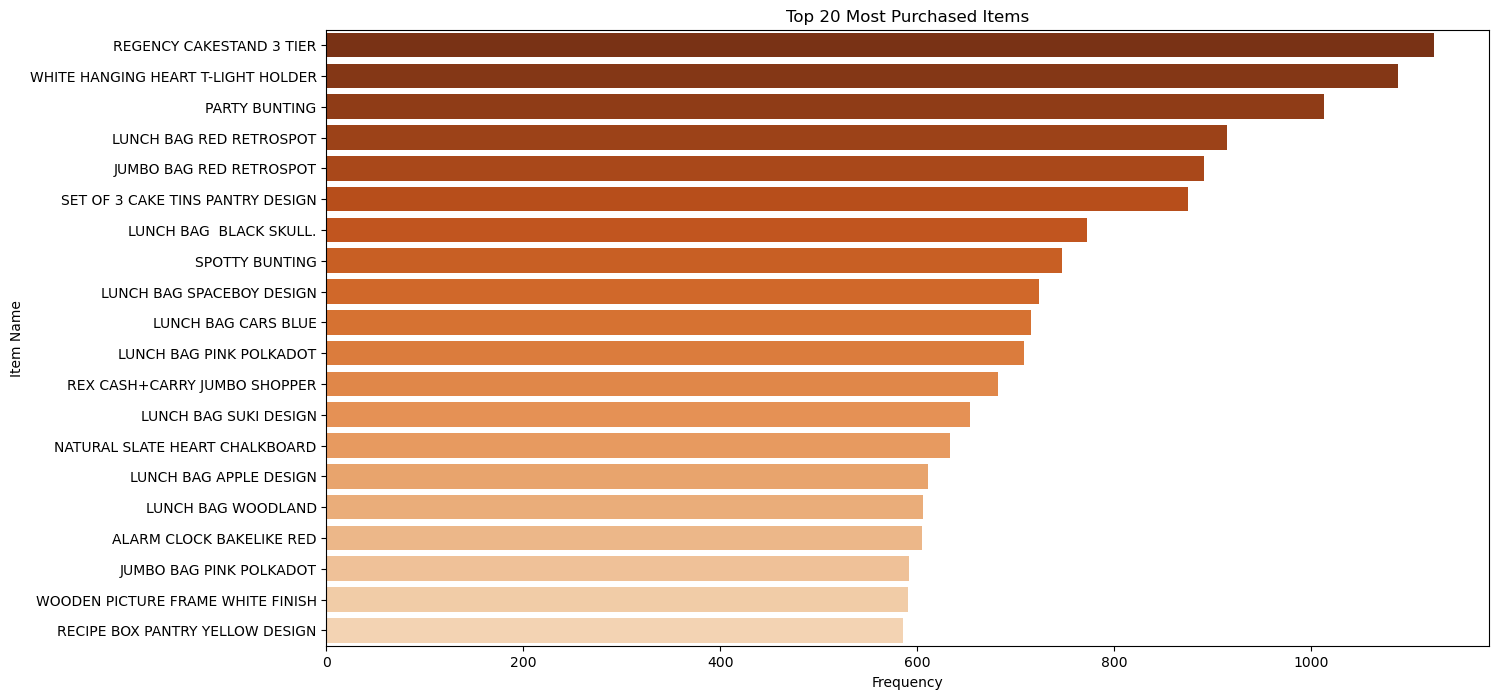

In [8]:
# Source: ChatGPT-3.5 
# Prompt: Create a visualization showcasing the top 20 most purchased items from a dataset called big_train. Utilize seaborn to generate a horizontal bar plot (countplot) with the 
# items on the y-axis and their frequency of purchase on the x-axis. Ensure the plot is titled 'Top 20 Most Purchased Items' with appropriate labels for the axes. Use the color palette 'Oranges_r' with 25 shades for the bars.

palette = sns.color_palette("Oranges_r", 25)

# Plot the top 20 most purchased items
plt.figure(figsize=(15, 8))
sns.countplot(y='Itemname', data=big_train, order=big_train['Itemname'].value_counts().iloc[:20].index, palette=palette)
plt.title('Top 20 Most Purchased Items')
plt.xlabel('Frequency')
plt.ylabel('Item Name')
plt.show()

It is important to understand the relationship between variables in our data set. A correlation matrix can help us identify this relationship.

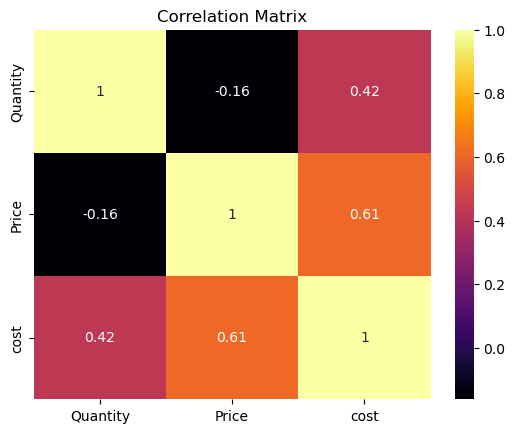

In [9]:
# Source: ChatGPT-3.5
# Prompt: "Generate a correlation matrix heatmap for the variables 'Quantity', 'Price', and 'cost' from the dataset 'big_train'. Utilize seaborn to create the heatmap with annotations (annot=True) and colormap 'inferno'. 
# Ensure the plot is titled 'Correlation Matrix'."
# Correlation Analysis
correlation_matrix = big_train[['Quantity', 'Price', 'cost']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.title('Correlation Matrix')
plt.show()

As we can see, there is a somewhat strong relationship between the price and the cost, whereas price and quantity seem to also have a moderate relation. Price and Quantity on the other hand do not seem to be very closely correlated.

With the help of the date of the purchase, we can go ahead and plot our daily sales for the entire data set and have a look at the graph to understand any patterns or seasonalities.

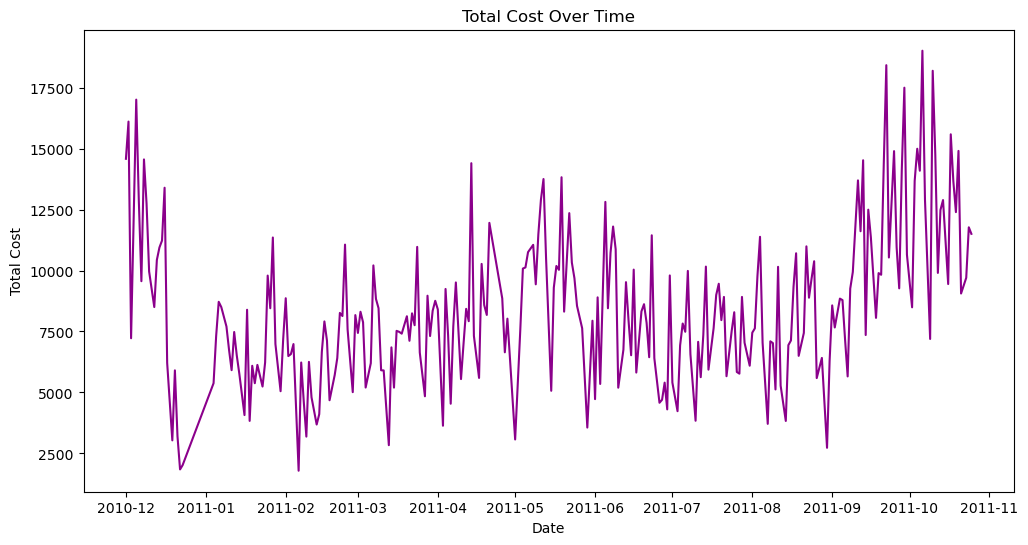

In [10]:
# Temporal Analysis
big_train['Date'] = pd.to_datetime(big_train['Date'], format='%d/%m/%Y %H:%M')
plt.figure(figsize=(12, 6))
big_train.groupby(big_train['Date'].dt.date)['cost'].sum().plot(color='darkmagenta')  # Change the color parameter here
plt.title('Total Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.show()

We can see that during the last months of the year, sales tend to boost up as compared to the rest of the year. This hike in sales can be seen during the months of October to December, which declines starting the month of January.

We can also have a look on the monthly sales report to get further confirmation on our initial observation.

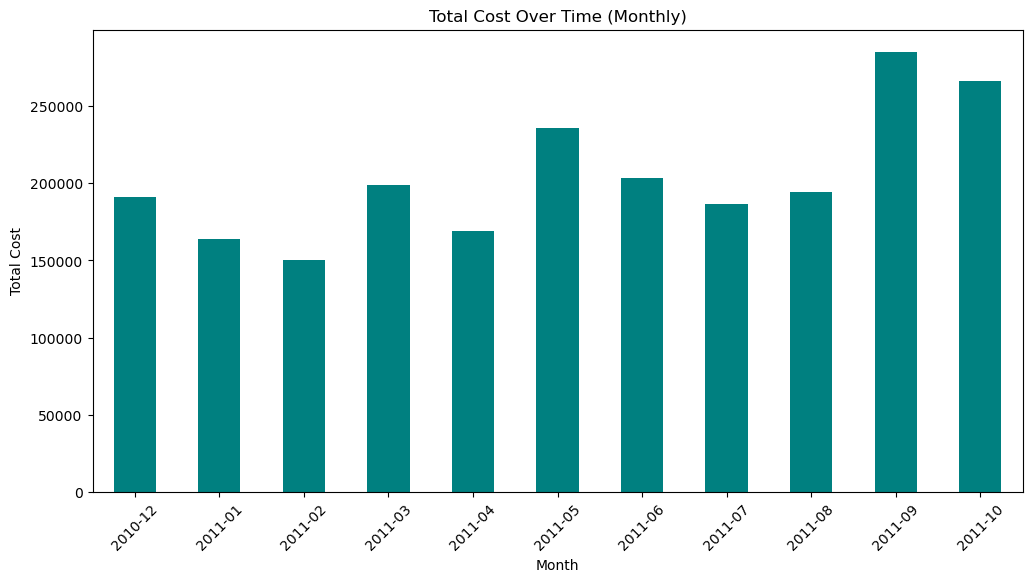

In [11]:
# Source: ChatGPT-3.5
# Prompt: Plot the total cost over time on a monthly basis using a bar plot. Set the color parameter to 'teal' for the bars. 
# Ensure the plot is titled 'Total Cost Over Time (Monthly)' with appropriate labels for the axes, and rotate the x-axis labels by 45 degrees for better readability.


# Extract month from the 'Date' column
big_train['Month'] = big_train['Date'].dt.to_period('M')

# Group by month and calculate the sum of the 'cost' column
monthly_cost = big_train.groupby(big_train['Month'])['cost'].sum()

# Plot the trend by month
plt.figure(figsize=(12, 6))
monthly_cost.plot(kind='bar', color="teal")
plt.title('Total Cost Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.xticks(rotation=45)
plt.show()

The histogram proves our initial observation to be correct. Sales do seem to spike at the end of the year.

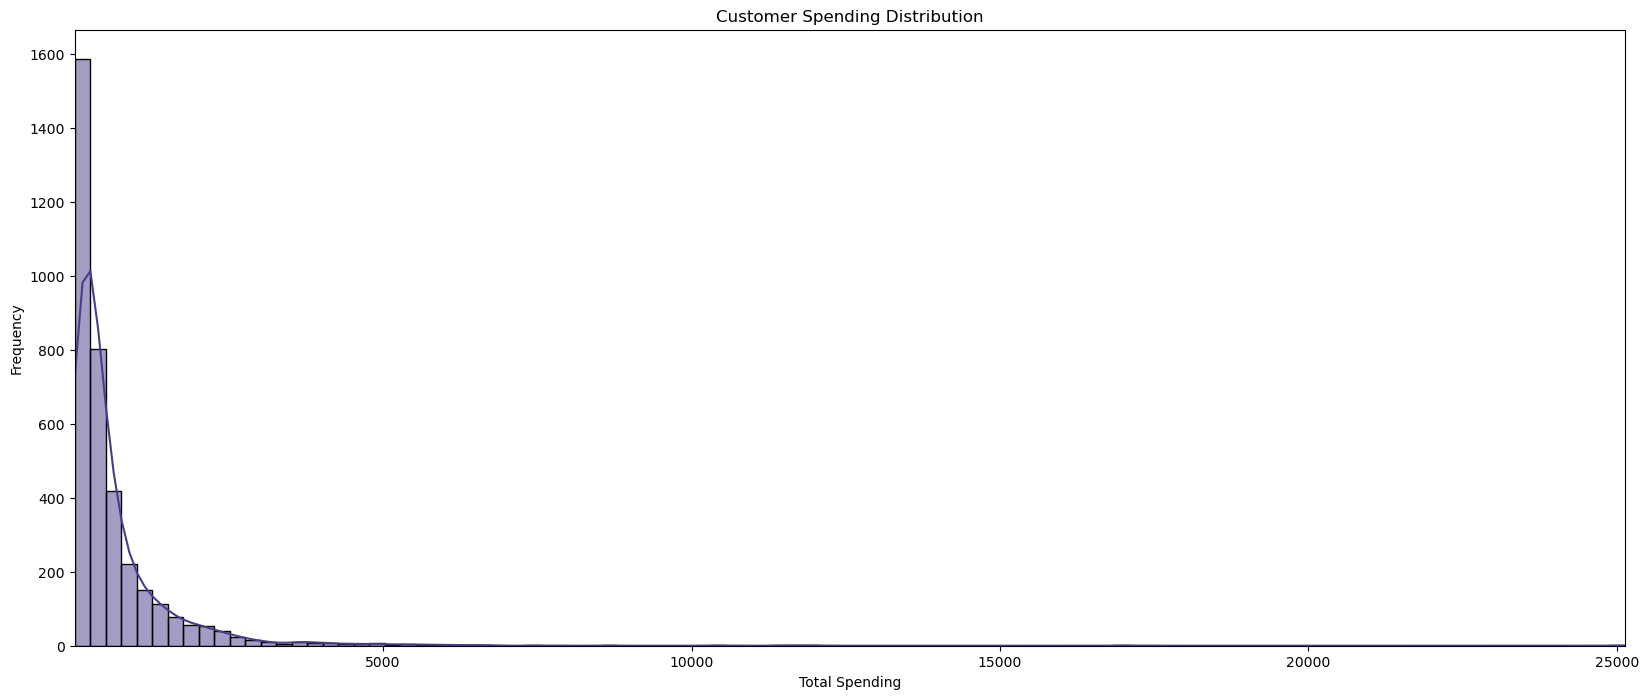

In [12]:
# Source: ChatGPT-3.5
# Prompt: Plot the distribution of customer spending using a histogram with 100 bins and kernel density estimation (kde) enabled. Set the color parameter to 'darkslateblue' for the histogram bars. 
# Ensure the plot is titled 'Customer Spending Distribution' with appropriate labels for the axes, and limit the x-axis to the range of the total spending data.


big_train['Total Spending'] = big_train['Quantity'] * big_train['Price']

# Customer Segmentation
# Explore customer segments based on 'CustomerID'
customer_segments = big_train.groupby('CustomerID')['cost'].sum().reset_index()
plt.figure(figsize=(20, 8))
sns.histplot(customer_segments['cost'], bins=100, kde=True, color="darkslateblue")
plt.title('Customer Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Frequency')
plt.xlim(customer_segments['cost'].min(), customer_segments['cost'].max())
plt.show()

We can observe here that as the number of items in the shopping basket increase, the frequency of the items seems to decrease.

In [13]:
# Checking for null values
print(train.isnull().sum())
train.describe()

# Changing the format of 'Date' col tu Datetime format
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y %H:%M')

Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64


As our data is all free of null values, we can proceed ahead with our data pre processing.

### Data Preprocessing

In [14]:
# Group the items by customer ID so that we can provide recommendations for each customer based on their previous baskets
all_items = set()  # Set to store all unique items

def create_customer_info_matrix(df):
    customer_info_dict = {}
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        customer_id = row['CustomerID']
        item_name = row['Itemname']
        
        # Add the item to the set of all items
        all_items.add(item_name)
        
        # Check if the customer ID is already in the dictionary
        if customer_id in customer_info_dict:
            # Set the value to 1 if the item is present for the customer, otherwise 0
            customer_info_dict[customer_id][item_name] = 1.0
        else:
            # Create a new entry for the customer and initialize all items to 0
            customer_info_dict[customer_id] = {item: 0.0 for item in all_items}
            # Set the value to 1 for the current item
            customer_info_dict[customer_id][item_name] = 1.0
    
    # Convert the dictionary to a DataFrame
    customer_info_matrix = pd.DataFrame.from_dict(customer_info_dict, orient='index').fillna(0.0)
    return customer_info_matrix


We will now create both customer info matrices for both train and test data. This step ensures common transformation for both data sets and maintain compatibility.

In [15]:
# Creating the customer information train and test DataFrames
customer_info_df = create_customer_info_matrix(train)
customer_info_df_test = create_customer_info_matrix(test)

In [16]:
customer_info_df

,KNITTED UNION FLAG HOT WATER BOTTLE,GLASS STAR FROSTED T-LIGHT HOLDER,WHITE HANGING HEART T-LIGHT HOLDER,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,CREAM CUPID HEARTS COAT HANGER,WHITE METAL LANTERN,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,WOOD 2 DRAWER CABINET WHITE FINISH,...,CRACKED GLAZE EARRINGS BROWN,WHITE VINT ART DECO CRYSTAL NECKLAC,WHITE VINTAGE CRYSTAL EARRINGS,BLACK VINT ART DEC CRYSTAL NECKLACE,NEW BAROQUE SMALL NECKLACE BLACK,GLITTER HEART DECORATION,GRASS HOPPER WOODEN WALL CLOCK,ASSORTED TUTTI FRUTTI KEYRING BALL,STANDING FAIRY POLE SUPPORT,FUSCHIA TABLE RUN FLOWER
17850,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15311,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
customer_info_df_test

,HEART FILIGREE DOVE LARGE,SILVER DISCO HANDBAG,METAL SIGN TAKE IT OR LEAVE IT,GOLD MINI TAPE MEASURE,"SMALL POP BOX,FUNKY MONKEY",SET OF 3 BLACK FLYING DUCKS,NAMASTE SWAGAT INCENSE,RED HARMONICA IN BOX,CHRYSANTHEMUM JOURNAL,POLKADOT PEN,...,CROCHET ROSE DES CLOTHES HANGER,BABY MOUSE RED GINGHAM DRESS,BLUE HOLE PUNCH,PAPERWEIGHT KINGS CHOICE,BULL DOG BOTTLE TOP WALL CLOCK,CLASSICAL ROSE CANDLESTAND,HAIRCLIPS FORTIES FABRIC ASSORTED,FRENCH STYLE STORAGE JAR BONBONS,FRENCH STYLE STORAGE JAR CAFE,NaN
15311.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12594.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16401.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16814.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Implementing FP growth

In [18]:
# FP growth and association rules
def fp_association_rules(customer_info_df, min_support, min_confidence):
    """
    Takes the following parameters as input:
    df : DataFrame containing transaction information (e.g., customer_info_matrix).
    min_support : The minimum support threshold for considering an itemset frequent.
    min_confidence : The minimum confidence threshold for generating association rules.

    Returns the following as output:
    frequent_itemsets : A DataFrame containing frequent itemsets.
    rules : A DataFrame containing association rules with their support, confidence, and lift values.
    """
    # Converting the matrix, since, FP-Growth algorithm needs the input in boolean values
    customer_info_df_bool = customer_info_df.astype(bool)
    
    # Mining the frequent itemsets
    frequent_itemsets = fpgrowth(customer_info_df_bool, min_support=min_support, use_colnames=True)

    # Generating association rules
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)


    return frequent_itemsets, rules

We can now define our min_support and min_confidence to generate frequent_itemsets and rules for our data set. After doing hit and run trial, the most suitable values for these have been chosen, keeping our data in mind.

In [19]:
min_support = 0.003
min_confidence = 0.8
frequent_itemsets, rules = fp_association_rules(customer_info_df, min_support, min_confidence)

In [20]:
frequent_itemsets

,support,itemsets
0,0.146657,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.065421,(WOODEN FRAME ANTIQUE WHITE)
2,0.057513,(WOODEN PICTURE FRAME WHITE FINISH)
3,0.051042,(KNITTED UNION FLAG HOT WATER BOTTLE)
4,0.051042,(RED WOOLLY HOTTIE WHITE HEART.)
...,...,...
208193,0.003595,"(ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA..."
208194,0.004313,"(JIGSAW RABBIT AND BIRDHOUSE, JIGSAW TREE WITH..."
208195,0.004313,"(JIGSAW TREE WITH BIRDHOUSE, JIGSAW TREE WITH ..."
208196,0.003595,"(SET OF 3 CAKE TINS PANTRY DESIGN, JIGSAW TREE..."


In [21]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(RED HANGING HEART T-LIGHT HOLDER, WOODEN FRAM...",(WHITE HANGING HEART T-LIGHT HOLDER),0.005751,0.146657,0.005032,0.875000,5.966299,0.004189,6.826743,0.837207
1,"(WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FR...",(LOVE BUILDING BLOCK WORD),0.008627,0.081237,0.007189,0.833333,10.258112,0.006488,5.512581,0.910370
2,"(RED HANGING HEART T-LIGHT HOLDER, WOODEN FRAM...",(WHITE HANGING HEART T-LIGHT HOLDER),0.005751,0.146657,0.005032,0.875000,5.966299,0.004189,6.826743,0.837207
3,"(RED HANGING HEART T-LIGHT HOLDER, WOODEN FRAM...",(LOVE BUILDING BLOCK WORD),0.005751,0.081237,0.005032,0.875000,10.771018,0.004565,7.350108,0.912406
4,"(RED HANGING HEART T-LIGHT HOLDER, WOODEN FRAM...",(HOME BUILDING BLOCK WORD),0.005751,0.081237,0.005032,0.875000,10.771018,0.004565,7.350108,0.912406
...,...,...,...,...,...,...,...,...,...,...
1879118,(METAL TUBE CHIME ON BAMBOO),(WHITE HANGING HEART T-LIGHT HOLDER),0.004313,0.146657,0.003595,0.833333,5.682190,0.002962,5.120058,0.827581
1879119,(HELLO SAILOR BLUE SOAP HOLDER),(FAIRY SOAP SOAP HOLDER),0.003595,0.013659,0.003595,1.000000,73.210526,0.003545,inf,0.989899
1879120,"(PICNIC BOXES SET OF 3 RETROSPOT, ROUND SNACK ...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.004313,0.038821,0.003595,0.833333,21.466049,0.003427,5.767074,0.957545
1879121,"(JIGSAW RABBIT AND BIRDHOUSE, JIGSAW TREE WITH...",(JIGSAW TREE WITH BIRDHOUSE),0.004313,0.008627,0.003595,0.833333,96.597222,0.003557,5.948239,0.993935


Doing the same process for our test data.

In [22]:
min_support_test = 0.0001
min_confidence_test = 0.8
frequent_itemsets_test, rules_test = fp_association_rules(customer_info_df_test, min_support_test, min_confidence_test)


In [23]:
frequent_itemsets_test

,support,itemsets
0,0.000917,(JUMBO BAG PINK VINTAGE PAISLEY)
1,0.000885,(JUMBO SHOPPER VINTAGE RED PAISLEY)
2,0.000786,(LOVE BUILDING BLOCK WORD)
3,0.000754,(WOOD 2 DRAWER CABINET WHITE FINISH)
4,0.000754,(PAPER BUNTING RETROSPOT)
...,...,...
6556,0.000197,"(HANGING CHICK GREEN DECORATION, HANGING CHICK..."
6557,0.000197,"(TREASURE ISLAND BOOK BOX, BUFFALO BILL TREASU..."
6558,0.000197,"(TREASURE ISLAND BOOK BOX, ABC TREASURE BOOK BOX)"
6559,0.000164,"(ABC TREASURE BOOK BOX, BUFFALO BILL TREASURE ..."


In [24]:
# Filtering the rules based on the top 5 most frequent antecedents
# We have taken first 5 to handle level of detail in the analysis. The choice of "5" could be adjusted if a different number of top antecedents were deemed more relevant or informative for the particular task at hand.
frequent_antecedents = rules['antecedents'].value_counts().index[:5]
filtered_rules = rules[rules['antecedents'].isin(frequent_antecedents)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
496114,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...",(RED RETROSPOT CUP),0.004313,0.022286,0.004313,1.000000,44.870968,0.004217,inf,0.981949
496115,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...",(RED RETROSPOT BOWL),0.004313,0.023724,0.004313,1.000000,42.151515,0.004211,inf,0.980505
496116,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...",(RED 3 PIECE RETROSPOT CUTLERY SET),0.004313,0.043853,0.004313,1.000000,22.803279,0.004124,inf,0.960289
496121,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...","(RED RETROSPOT BOWL, RED RETROSPOT CUP)",0.004313,0.011503,0.004313,1.000000,86.937500,0.004264,inf,0.992780
496128,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...","(RED 3 PIECE RETROSPOT CUTLERY SET, RED RETROS...",0.004313,0.008627,0.004313,1.000000,115.916667,0.004276,inf,0.995668
...,...,...,...,...,...,...,...,...,...,...
1478483,"(PINK POLKADOT PLATE, RED RETROSPOT BOWL, BLU...","(RED 3 PIECE RETROSPOT CUTLERY SET, PINK 3 PIE...",0.004313,0.003595,0.003595,0.833333,231.833333,0.003579,5.978433,1.000000
1481429,"(RED RETROSPOT PLATE, RED RETROSPOT BOWL, BLUE...","(RED 3 PIECE RETROSPOT CUTLERY SET, PINK 3 PIE...",0.004313,0.003595,0.003595,0.833333,231.833333,0.003579,5.978433,1.000000
1481430,"(RED RETROSPOT PLATE, BLUE 3 PIECE POLKADOT CU...","(RED 3 PIECE RETROSPOT CUTLERY SET, PINK 3 PIE...",0.004313,0.003595,0.003595,0.833333,231.833333,0.003579,5.978433,1.000000
1481431,"(BLUE POLKADOT BOWL, BLUE 3 PIECE POLKADOT CUT...","(RED 3 PIECE RETROSPOT CUTLERY SET, PINK 3 PIE...",0.004313,0.003595,0.003595,0.833333,231.833333,0.003579,5.978433,1.000000


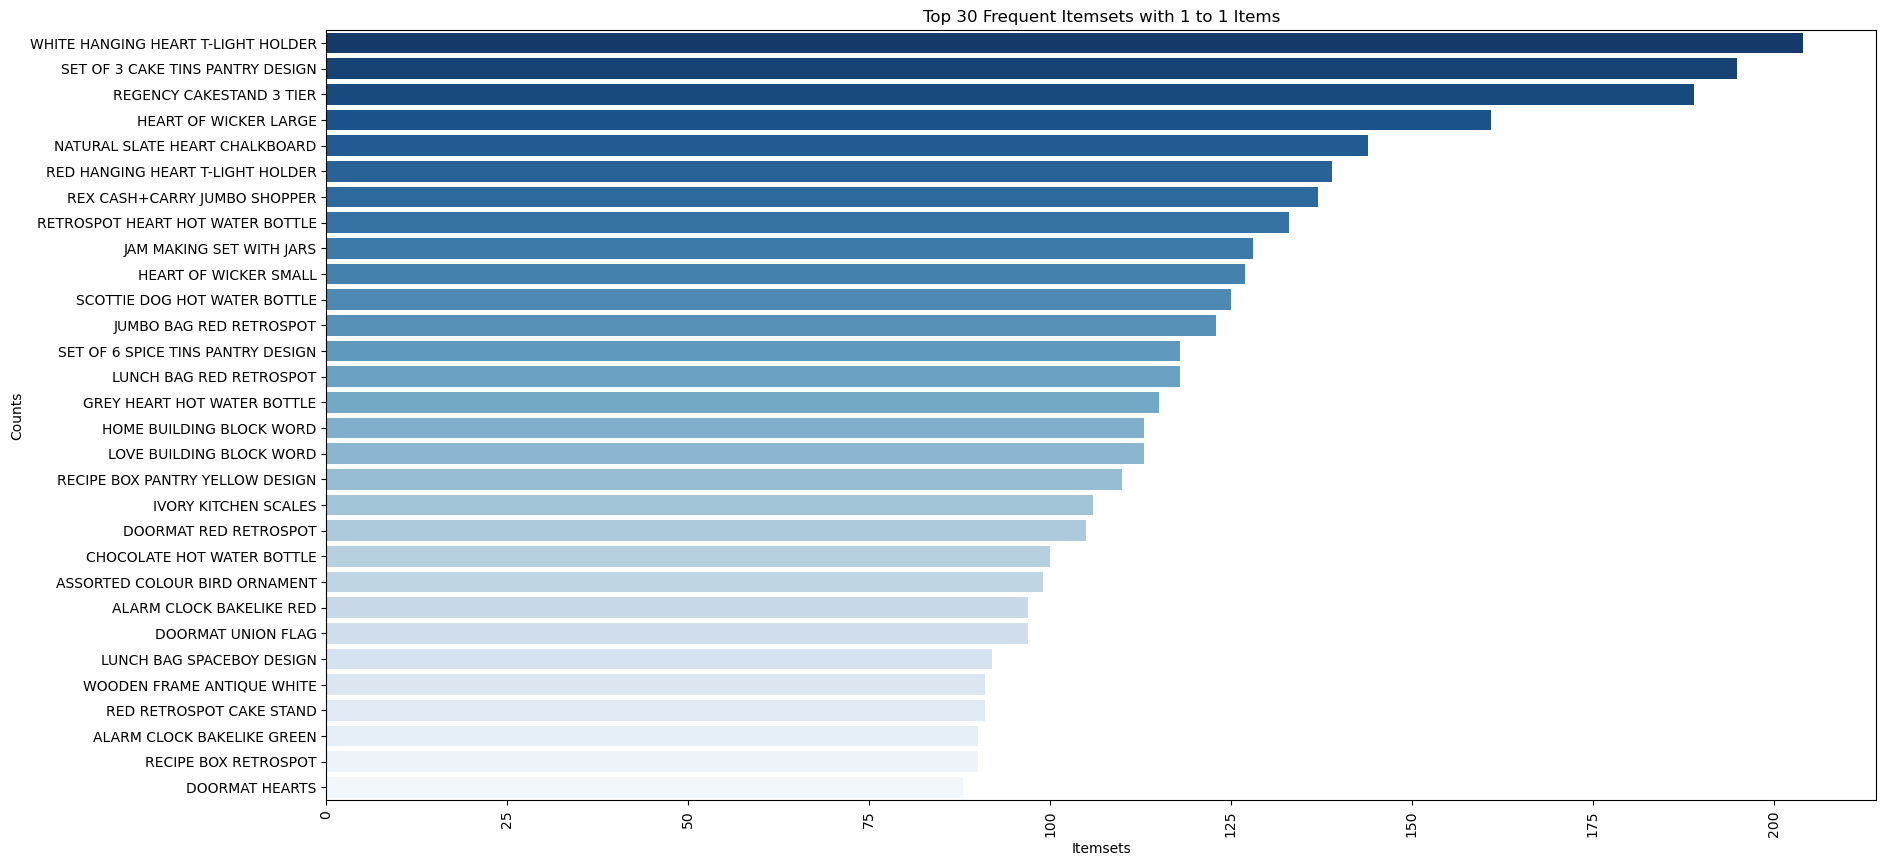

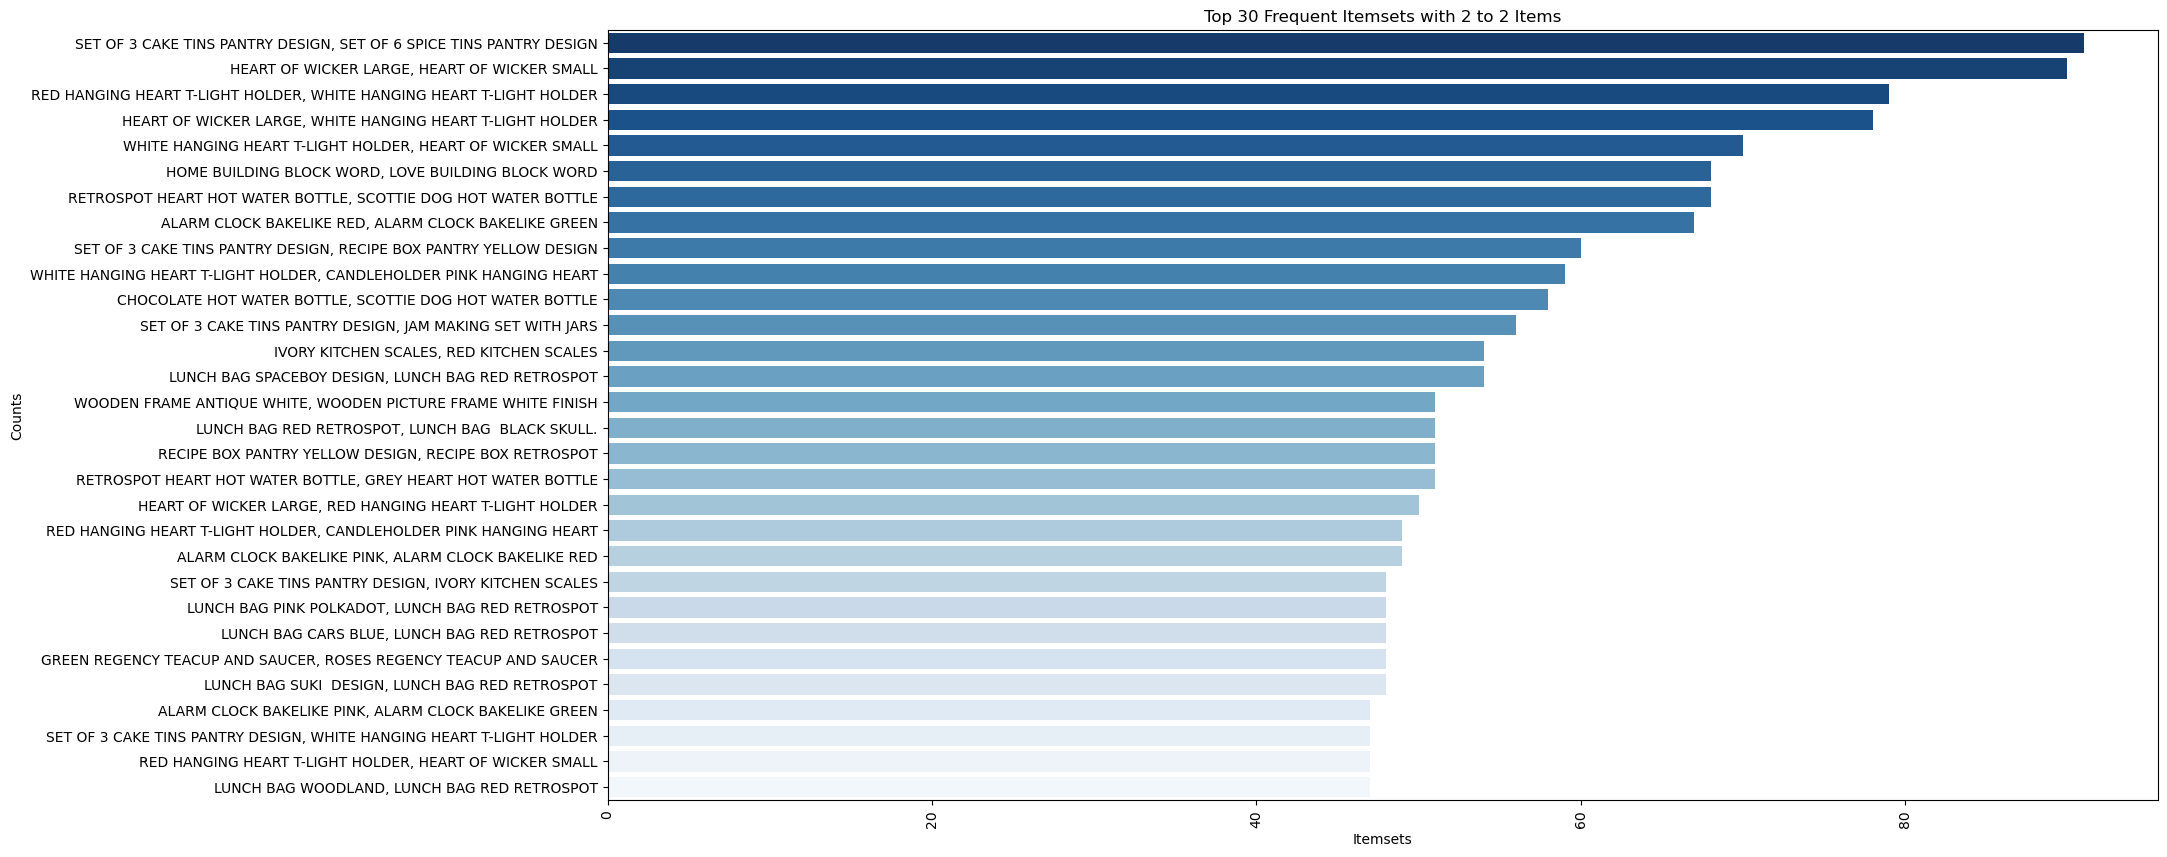

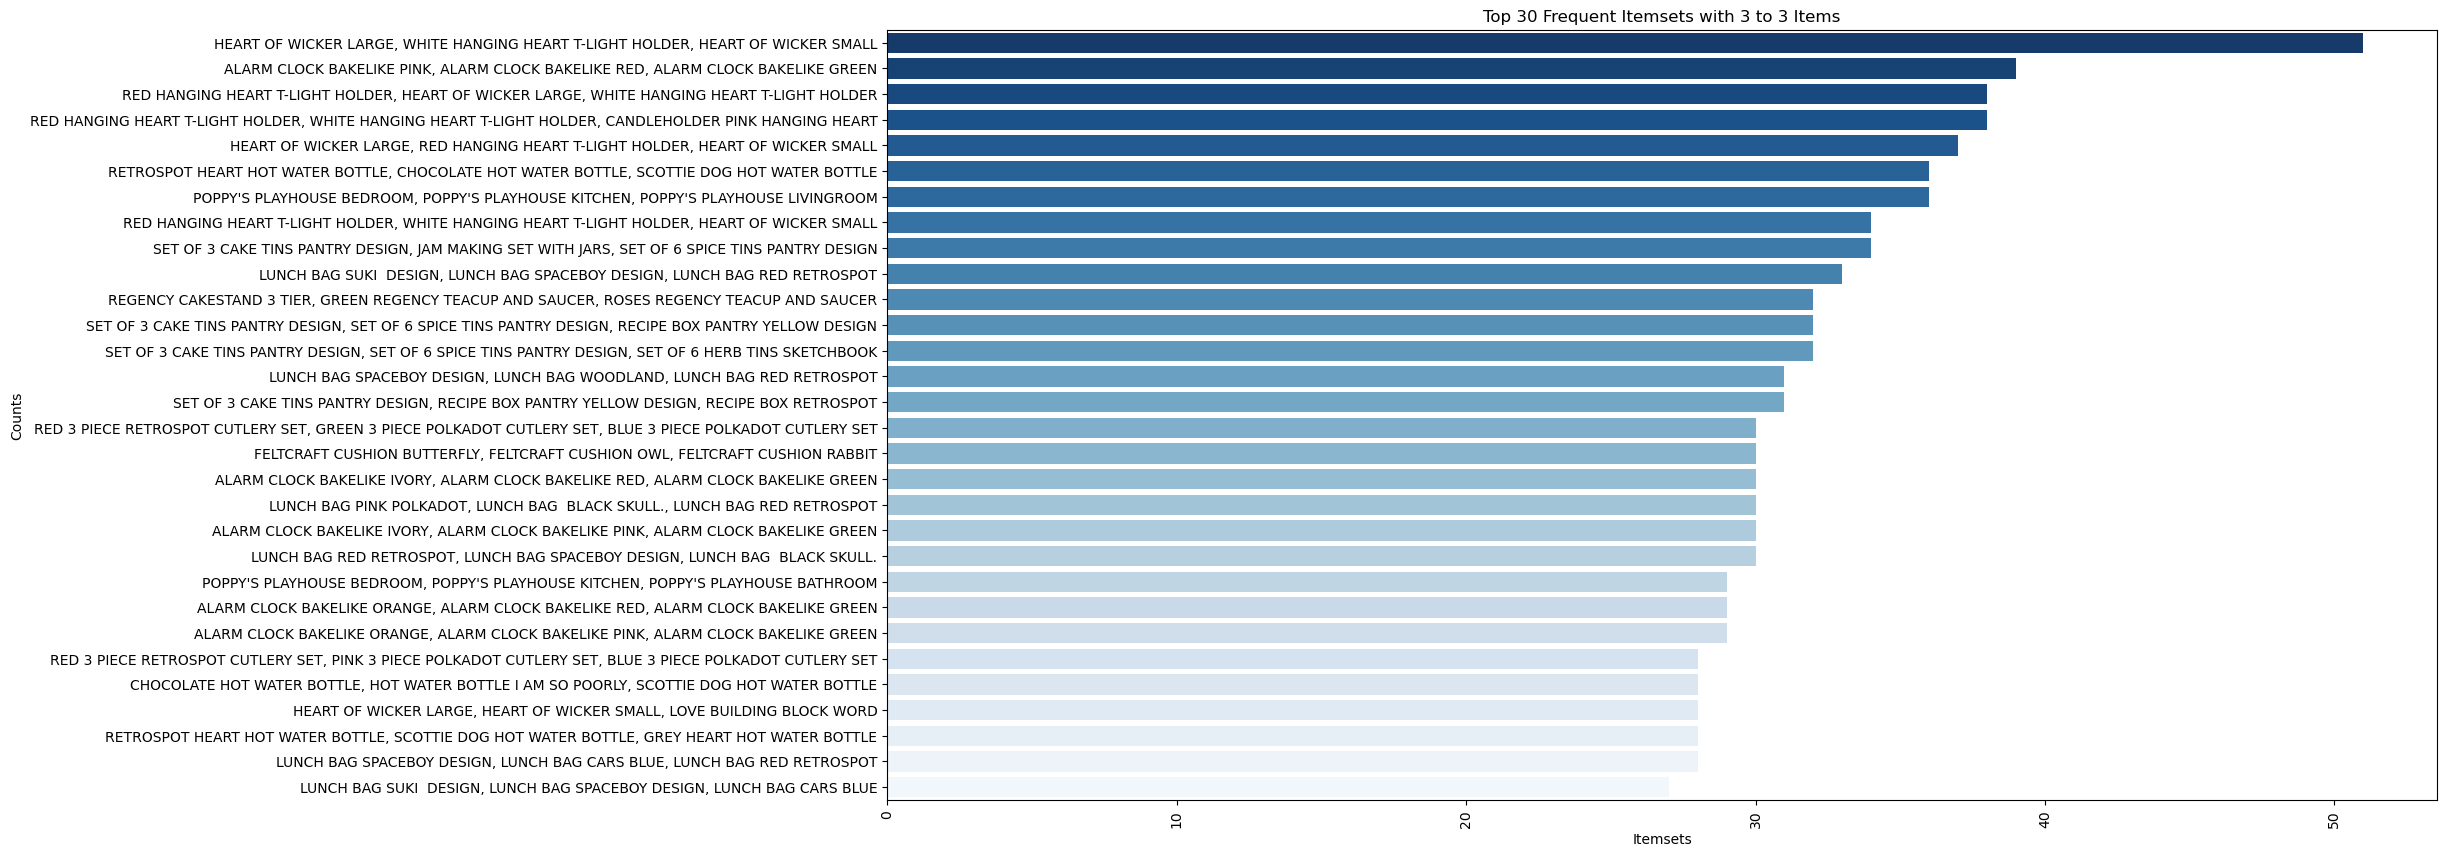

In [25]:
# Plotting top itemsets
def plot_top_itemsets(itemsets, min_items, max_items, top_n=100, figsize=(20, 10)):
    """
    Plots the top frequent itemsets based on the specified criteria.
    
    Parameters:
    itemsets (DataFrame): The frequent itemsets DataFrame.
    min_items (int): The minimum number of items in the itemset.
    max_items (int): The maximum number of items in the itemset.
    top_n (int): The number of top itemsets to plot.
    figsize (tuple): The figure size for the plot.
    """
    # Filter the frequent itemsets based on the number of items in each itemset
    filtered_itemsets = itemsets[itemsets['itemsets'].apply(lambda x: min_items <= len(x) <= max_items)]

    # Sort the filtered itemsets by support in descending order and select the top 50
    top_itemsets = filtered_itemsets.sort_values(by='support', ascending=False).head(top_n)

    # Extract the support values and convert them to counts
    count_values = (top_itemsets['support'] * len(customer_info_df)).tolist()

    # Create a DataFrame with the itemsets and their counts
    itemset_counts_df = pd.DataFrame({
        'itemsets': [', '.join(map(str, itemset)) for itemset in top_itemsets['itemsets']],
        'counts': count_values
    })

    # Plot an Seaborn barplot using the created DataFrame

    palette = sns.color_palette("Blues_r", n_colors=top_n)
    plt.figure(figsize=figsize)
    sns.barplot(data=itemset_counts_df, y='itemsets', x='counts', palette=palette)
    plt.xlabel('Itemsets')
    plt.ylabel('Counts')
    plt.xticks(rotation=90)
    plt.title(f'Top {top_n} Frequent Itemsets with {min_items} to {max_items} Items')
    plt.show()


# Printing top itemsets for 3 combinations, 1 to 3 items.
# Plot top 30 single itemsets
plot_top_itemsets(frequent_itemsets, min_items=1, max_items=1, top_n=30)

# Plot top 30 two-itemsets
plot_top_itemsets(frequent_itemsets, min_items=2, max_items=2, top_n=30)

# Plot top 30 three-itemsets
plot_top_itemsets(frequent_itemsets, min_items=3, max_items=3, top_n=30)

### Developing our Recommendation System

Since we have our data ready with us, we can use the data to find pattern and then the pattern to find recommendations. We will start with our data and generate recommendations. We will further find patterns in our data. In addition, we will be addressing the cold start problem as well, whos presence we confirmed at the start of our project.

#### Data to Recommendation

In [26]:
# Data2Recommendations
def calculate_item_similarities(customer_info_dict):
    """
    Calculates the Jaccard similarity between items in the transaction-item matrix.
    
    Parameters:
    customer_info_dict (DataFrame): The transaction-item matrix.
    
    Returns:
    DataFrame: The item similarity matrix.
    """
    # Calculate Jaccard similarities between items
    jaccard_similarities = 1 - pairwise_distances(customer_info_dict.T.to_numpy(), metric='jaccard')

    # Create a DataFrame of item similarities
    return pd.DataFrame(jaccard_similarities, index=customer_info_dict.columns, columns=customer_info_dict.columns)

def generate_recommendations_d2r(item_set, item_similarities, k=3, filter_input=True):
    """
    Generates recommendations using the Data2Recommendations approach.
    
    Parameters:
    item_set (list): The set of input items.
    item_similarities (DataFrame): The item similarity matrix.
    filter_input (bool): Whether to filter out the input items from the recommendations.
    
    Returns:
    list: The recommended items.
    """
    # Calculate the mean similarity score for the given item_set
    item_set = set(item_set)
    valid_items = [item for item in item_set if item in item_similarities.index]

    if not valid_items:
        return [] # No recommendations if no valid input items are found
    
    mean_similarity = item_similarities.loc[valid_items, :].mean(axis=0)
    
    if filter_input:
        # Remove the input item_set from the mean_similarity
        mean_similarity = mean_similarity.drop(labels=valid_items, errors='ignore')

    # Get the top k items based on mean_similarity
    top_k_items = mean_similarity.nlargest(k).index.tolist()

    return top_k_items

Now we will pass on some random items in our data set, to generate recommendations and frequent itemsets.

In [27]:
# Calculating item similarities
customer_info_df_bool = customer_info_df.astype(bool)
item_similarities = calculate_item_similarities(customer_info_df_bool)
items = ['SWEETHEART WIRE WALL TIDY', 'DOLLY GIRL LUNCH BOX', 'BLUE COAT RACK PARIS FASHION']

In [28]:
def print_recommendations(recommendations):
    for i in range (0, len(recommendations)):
        print(str(i+1) + ". " + recommendations[i])

In [29]:
# Generating D2R Recommendations
d2r_recommendations = generate_recommendations_d2r(items, item_similarities, k=10)

print("D2R Recommendations:")
print_recommendations(d2r_recommendations)

D2R Recommendations:
1. RED COAT RACK PARIS FASHION
2. YELLOW COAT RACK PARIS FASHION
3. SPACEBOY LUNCH BOX
4. CIRCUS PARADE LUNCH BOX
5. LUNCH BOX I LOVE LONDON
6. SOAP DISH BROCANTE
7. S/4 VALENTINE DECOUPAGE HEART BOX
8. CREAM CUPID HEARTS COAT HANGER
9. HOME SWEET HOME MUG
10. METAL 4 HOOK HANGER FRENCH CHATEAU


We have generated some recommendations from our sample data. We now have to check for how correct these predictions are. We have to evaluate the system in order to answer this. We will evaluate our system on multiple metrics- Precision, Root Mean Square Error (RMSE) and Average Reciprocal Hit Rate (ARHR). Along with this we will also evaluate the coverage and diversity of our model.

In [30]:
# Source: ChatGPT-3.5
# Prompt: How to evaluate a recommender model using RMSE (Root Mean Squared Error), ARHR (Average Reciprocal Hit Rank), coverage, and diversity.

# Evaluation Method
def evaluate_recommendation_system(customer_info_df_test, k=10, n=1000):
    # Initialize metric variables
    count = 0
    total_precision = 0
    total_rmse = 0
    total_arhr = 0
    total_recommendations = 0
    recommended_items = set()
    
    # Calculate ietem similarities for the test dataset
    item_similatities_test = calculate_item_similarities(customer_info_df_test.astype(bool))

    # Iterate through the test customer data
    for _, row in customer_info_df_test.iterrows():
        if count >= n:
            break

        # Get the items in the current test customer
        items_for_customer = set(row[row > 0].index)

        # Randomly select one item from the customer item list as input
        input_items = set(random.sample(list(items_for_customer), k=1))

        # Generate recommendations using the model
        recommendations = generate_recommendations_d2r(input_items, item_similatities_test, k=k)

        # Update the set of all recommended items
        recommended_items.update(recommendations)
        
        # Get the remaining items in the customer item list after removing the input item
        remaining_items_for_customer = items_for_customer - input_items

        # Count the number of correct recommendations
        correct_recommendations = len(recommended_items.intersection(remaining_items_for_customer))

        # Calculate Precision
        precision = correct_recommendations / k
        total_precision += precision

        if recommendations:
            # Calculate RMSE
            y_true = [1 if item in remaining_items_for_customer else 0 for item in recommendations]
            y_pred = [1 if item in recommended_items else 0 for item in recommendations]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            total_rmse += rmse

            # Calculate ARHR
            hits = 0
            sum_one_by_rank = 0
            for rank, item in enumerate(recommendations, 1):
                if item in remaining_items_for_customer:
                    hits += 1
                    sum_one_by_rank += 1 / rank
            arhr = sum_one_by_rank / hits if hits > 0 else 0
            total_arhr += arhr

        # Update the total number of recommendations and processed transactions
        total_recommendations += k
        count += 1

    # Calculate Coverage
    coverage = len(recommended_items) / len(customer_info_df_test.columns)

    # Calculate Diversity
    diversity_total = 0
    pairs = 0

    for i, item1 in enumerate(recommended_items):
        for item2 in list(recommended_items)[i+1:]:
            similarity = item_similatities_test.loc[item1, item2]
            diversity_total += 1 - similarity
            pairs += 1

    diversity = diversity_total / pairs

    # Calculate average metrics
    avg_precision = total_precision / count
    avg_rmse = total_rmse / count
    avg_arhr = total_arhr / count

    return avg_precision, avg_rmse, avg_arhr, coverage, diversity


Testing our system on the test data set, for 100 items. 

In [31]:
# Calculating the accuracy of D2R Recommendation using customer test dataset 
d2r_results = ["Data2Recommendations", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)]

In [32]:
# Define the table headers
headers = ["Model", "Avg Precision", "Avg RMSE", "Avg ARHR", "Coverage", "Diversity"]

# Create the tabulate table
table = tabulate([d2r_results], headers=headers, tablefmt="grid")
print(table)

+----------------------+-----------------+------------+------------+------------+-------------+
| Model                |   Avg Precision |   Avg RMSE |   Avg ARHR |   Coverage |   Diversity |
+======================+=================+============+============+============+=============+
| Data2Recommendations |         1.44667 |   0.720687 |   0.449444 |  0.0889478 |    0.980512 |
+----------------------+-----------------+------------+------------+------------+-------------+


Now that we have our frequent itemsets, we will do ahead and use the patterns to find recommendations.

### Pattern to Recommendation

In [33]:
# Pattern2Recommendations
def filter_frequent_itemsets(customer_info_df, frequent_itemsets):
    """
    Filters the transaction-item matrix to include only the frequent items.
    
    Parameters:
    transaction_item_matrix (DataFrame): The transaction-item matrix.
    frequent_itemsets (DataFrame): The frequent itemsets DataFrame.
    
    Returns:
    DataFrame: The filtered transaction-item matrix.
    """
    # Collect all frequent items from the frequent itemsets
    frequent_items = set()
    for _, row in frequent_itemsets.iterrows():
        for item in row['itemsets']:
            frequent_items.add(item)

    # Return a filtered transaction-item matrix containing only frequent items
    return customer_info_df[list(frequent_items)]

def get_itemsets_support(frequent_itemsets):
    """
    Creates a dictionary of itemsets and their support values.
    
    Parameters:
    frequent_itemsets (DataFrame): The frequent itemsets DataFrame.
    
    Returns:
    dict: The dictionary of itemsets and their support values.
    """
    itemsets_support = {}
    for _, row in frequent_itemsets.iterrows():
        itemsets_support[frozenset(row['itemsets'])] = row['support']
    return itemsets_support

def generate_recommendations_p2r(item_set, item_similarities, frequent_itemsets, itemsets_support, k, filter_input=True):
    """
    Generates recommendations using the Pattern2Recommendations approach.
    
    Parameters:
    item_set (list): The set of input items.
    item_similarities (DataFrame): The item similarity matrix.
    frequent_itemsets (DataFrame): The frequent itemsets DataFrame.
    itemsets_support (dict): The dictionary of itemsets and their support values.
    filter_input (bool): Whether to filter out the input items from the recommendations.
    
    Returns:
    list: The recommended items.
    """
    # Calculate the mean similarity score for the given item_set
    item_set = set(item_set)
    valid_items = [item for item in item_set if item in item_similarities.index]
    
    if not valid_items:
        return [] # No recommendations if no valid input items are found
    
    # Check if all items are frequent
    all_items_frequent = all(item in frequent_itemsets for item in valid_items)

    if all_items_frequent:
        # Generate recommendations using frequent itemsets
        mean_similarity = item_similarities.loc[valid_items, :].mean(axis=0)
    else:
        # Use item similarity matrix for non-frequent items
        mean_similarity = item_similarities.loc[valid_items, :].mean(axis=0)
    
    if filter_input:
        # Remove the input item_set from the mean_similarity
        mean_similarity = mean_similarity.drop(labels=valid_items, errors='ignore')
    
    # Get the top k items based on mean_similarity
    top_k_items = mean_similarity.nlargest(k).index.tolist()

    # Rank the top k items by their support in the frequent itemsets
    top_k_items_support = [(item, itemsets_support[frozenset({item})]) for item in top_k_items]
    top_k_items_support.sort(key=lambda x: x[1], reverse=True)

    # Return the top k recommended items based on support
    return [item for item, _ in top_k_items_support]

In [34]:
frequent_transaction_itemset = filter_frequent_itemsets(customer_info_df_bool, frequent_itemsets)
itemsets_support = get_itemsets_support(frequent_itemsets)

In [35]:
# Generating P2R Recommendations
p2r_recommendations = generate_recommendations_p2r(items, item_similarities, frequent_itemsets, itemsets_support, k=10)

print("P2R Recommendations:")
print_recommendations(p2r_recommendations)

P2R Recommendations:
1. METAL 4 HOOK HANGER FRENCH CHATEAU
2. CREAM CUPID HEARTS COAT HANGER
3. LUNCH BOX I LOVE LONDON
4. SPACEBOY LUNCH BOX
5. S/4 VALENTINE DECOUPAGE HEART BOX
6. RED COAT RACK PARIS FASHION
7. YELLOW COAT RACK PARIS FASHION
8. HOME SWEET HOME MUG
9. CIRCUS PARADE LUNCH BOX
10. SOAP DISH BROCANTE


In [36]:
# Calculating the accuracy of P2R Recommendation using customer test dataset 
p2r_results = ["Pattern2Recommendations", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)]

In [37]:
# Create the tabulate table
table = tabulate([p2r_results], headers=headers, tablefmt="grid")
print(table)

+-------------------------+-----------------+------------+------------+------------+-------------+
| Model                   |   Avg Precision |   Avg RMSE |   Avg ARHR |   Coverage |   Diversity |
+=========================+=================+============+============+============+=============+
| Pattern2Recommendations |            1.52 |   0.683367 |     0.4675 |  0.0893263 |    0.981639 |
+-------------------------+-----------------+------------+------------+------------+-------------+


### Popular Items Recommendation

For a cold start problem for a user, we have no information of any sorts to provide recommendations to our user. In such cases, providing the best selling items can mostly prove to be the best recommendations, as they are the most popular ones.

In [38]:
# PopularItemsRecommendations
def generate_popular_recommendations(customer_info_df, k=10):
    """
    Generates recommendations based on the most popular items.
    
    Parameters:
    transaction_item_matrix (DataFrame): The transaction-item matrix.
    k (int): The number of recommendations to generate.
    
    Returns:
    list: The recommended items.
    """
    # Calculate item popularity by counting the number of transactions for each item
    item_popularity = customer_info_df.sum(axis=0)

    # Sort items by popularity in descending order
    popular_items = item_popularity.sort_values(ascending=False).index.tolist()

    # Recommend the top k popular items
    top_k_popular_items = popular_items[:k]
    
    return top_k_popular_items

In [39]:
# Generate recommendations for the most popular items
popular_recommendations = generate_popular_recommendations(customer_info_df_test, k=10)

print("Popular Recommendations:")
print_recommendations(popular_recommendations)

Popular Recommendations:
1. SET OF 3 CAKE TINS PANTRY DESIGN
2. REGENCY CAKESTAND 3 TIER
3. SET OF 6 SPICE TINS PANTRY DESIGN
4. WHITE HANGING HEART T-LIGHT HOLDER
5. JAM MAKING SET WITH JARS
6. ROSES REGENCY TEACUP AND SAUCER
7. NATURAL SLATE HEART CHALKBOARD
8. GREEN REGENCY TEACUP AND SAUCER
9. JUMBO BAG RED RETROSPOT
10. VINTAGE UNION JACK BUNTING


### Addressing Cold Start

Now when the recommender comes across a item which it has never seen, it still generates recommendations with the help of frequent_itemsets. (As per the Specification Document)

In [40]:
# Pattern2RecommendationsWithColdStart
def calculate_similarity_cold_start(item1, item2):
    """
    Calculates the Jaccard similarity between two items.
    
    Parameters:
    item1 (str): The first item.
    item2 (str): The second item.
    
    Returns:
    float: The Jaccard similarity between the two items.
    """
    # Create sets for both items
    set1 = set(item1)
    set2 = set(item2)

    # Find the length of intersection and union of the two sets
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    # Calculate similarity score
    similarity = intersection / union if union != 0 else 0
    
    return similarity

def find_similar_item_cold_start(item, frequent_itemsets, item_similarities):
    """
    Finds the most similar item to the given item from the frequent itemsets.
    
    Parameters:
    item (str): The input item.
    frequent_itemsets (DataFrame): The frequent itemsets DataFrame.
    item_similarities (DataFrame): The item similarity matrix.
    
    Returns:
    str or None: The most similar item if found, otherwise None.
    """
    # Find the most similar item in the frequent itemsets based on item name similarity
    similarities = []
    for frequent_item in frequent_itemsets:
        similarity = calculate_similarity_cold_start(item, frequent_item)
        similarities.append((frequent_item, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return the most similar item if similarity is above a certain threshold
    threshold = 0.8
    most_similar_item = similarities[0][0] if similarities[0][1] > threshold else None
    
    return most_similar_item

def generate_recommendations_p2r_cold_start(item_set, item_similarities, frequent_itemsets, filter_input=True):
    """
    Generates recommendations using the Pattern2RecommendationsWithColdStart approach.
    
    Parameters:
    item_set (list): The set of input items.
    item_similarities (DataFrame): The item similarity matrix.
    frequent_itemsets (DataFrame): The frequent itemsets DataFrame.
    filter_input (bool): Whether to filter out the input items from the recommendations.
    
    Returns:
    list: The recommended items.
    """
    # Calculate the mean similarity score for the given item_set
    item_set = set(item_set)
    valid_items = [item for item in item_set if item in item_similarities.index]

    if not valid_items:
        return [] # No recommendations if no valid input items are found
    
    # Check if all items are frequent
    all_items_frequent = all(item in frequent_itemsets for item in valid_items)
    if all_items_frequent:
        # Generate recommendations using frequent itemsets
        mean_similarity = item_similarities.loc[valid_items, :].mean(axis=0)
    else:
        # Use item similarity matrix for non-frequent items
        mean_similarity = item_similarities.loc[valid_items, :].mean(axis=0)
    
    if filter_input:
        # Remove the input item_set from the mean_similarity
        mean_similarity = mean_similarity.drop(labels=valid_items, errors='ignore')
    
    # Get the top k items based on mean_similarity
    top_k_items = mean_similarity.nlargest(10).index.tolist()

    # If any of the top k items are not in the frequent itemsets, find a similar item by name
    for i, item in enumerate(top_k_items):
        if item not in frequent_itemsets:
            similar_item = find_similar_item_cold_start(item, frequent_itemsets, item_similarities)
            if similar_item:
                top_k_items[i] = similar_item
    
    return top_k_items

In [41]:
# Generating P2R (with Cold Start) Recommendations
p2r_cold_start_recommendations = generate_recommendations_p2r_cold_start(items, item_similarities, frequent_itemsets, itemsets_support)

print("P2R (with Cold Start) Recommendations:")
print_recommendations(p2r_cold_start_recommendations)

P2R (with Cold Start) Recommendations:
1. RED COAT RACK PARIS FASHION
2. YELLOW COAT RACK PARIS FASHION
3. SPACEBOY LUNCH BOX
4. CIRCUS PARADE LUNCH BOX
5. LUNCH BOX I LOVE LONDON
6. SOAP DISH BROCANTE
7. S/4 VALENTINE DECOUPAGE HEART BOX
8. CREAM CUPID HEARTS COAT HANGER
9. HOME SWEET HOME MUG
10. METAL 4 HOOK HANGER FRENCH CHATEAU


In [42]:
# Calculating the accuracy of P2R (with Cold Start) Recommendation using customer test dataset 
p2r_cold_start_results = ["Pattern2RecommendationsWithColdStart", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)]

In [43]:
# Create the tabulate table
table = tabulate([p2r_cold_start_results], headers=headers, tablefmt="grid")
print(table)

+--------------------------------------+-----------------+------------+------------+------------+-------------+
| Model                                |   Avg Precision |   Avg RMSE |   Avg ARHR |   Coverage |   Diversity |
+======================================+=================+============+============+============+=============+
| Pattern2RecommendationsWithColdStart |            1.51 |   0.757471 |   0.393611 |  0.0931113 |    0.978852 |
+--------------------------------------+-----------------+------------+------------+------------+-------------+


### Results

We now compare the results of all the three types of recommendations done in this project.

In [44]:
# Adding the P2R (with Cold Start) results into the results list
results = [d2r_results, p2r_results, p2r_cold_start_results]

# Table showing results of testing recommendations on the test set
table = tabulate(results, headers=headers, tablefmt="grid")
print(table)

+--------------------------------------+-----------------+------------+------------+------------+-------------+
| Model                                |   Avg Precision |   Avg RMSE |   Avg ARHR |   Coverage |   Diversity |
+======================================+=================+============+============+============+=============+
| Data2Recommendations                 |         1.44667 |   0.720687 |   0.449444 |  0.0889478 |    0.980512 |
+--------------------------------------+-----------------+------------+------------+------------+-------------+
| Pattern2Recommendations              |         1.52    |   0.683367 |   0.4675   |  0.0893263 |    0.981639 |
+--------------------------------------+-----------------+------------+------------+------------+-------------+
| Pattern2RecommendationsWithColdStart |         1.51    |   0.757471 |   0.393611 |  0.0931113 |    0.978852 |
+--------------------------------------+-----------------+------------+------------+------------+-------

In [45]:
# Discussion of results (Option 1)
# i. Five examples of recommendations that the user actually bought as evidenced in the test set
def test_recommendations_bought_by_user(customer_info_df_test, d2r_recommendations, p2r_recommendations, p2r_cold_start_recommendations):
    """
    Tests the recommendations generated by the different approaches and displays the ones that the user actually bought in the test set.
    
    Parameters:
    customer_info_df_test (DataFrame): The customer information DataFrame for the test set.
    d2r_recommendations (list): The recommendations generated by the Data2Recommendations approach.
    p2r_recommendations (list): The recommendations generated by the Pattern2Recommendations approach.
    p2r_cold_start_recommendations (list): The recommendations generated by the Pattern2RecommendationsWithColdStart approach.
    """
    # Create a set of all the items bought by the user in the test set
    items_bought_by_user = set(customer_info_df_test.columns)

    print("Five examples of recommendations that the user actually bought in the test set:")

    # Test D2R recommendations
    print("\nD2R Recommendations:")
    for i, recommendation in enumerate(d2r_recommendations):
        if recommendation in items_bought_by_user:
            print(f"{i+1}. {recommendation}")
            if i >= 4:
                break

    # Test P2R recommendations
    print("\nP2R Recommendations:")
    for i, recommendation in enumerate(p2r_recommendations):
        if recommendation in items_bought_by_user:
            print(f"{i+1}. {recommendation}")
            if i >= 4:
                break

    # Test P2R (with Cold Start) recommendations
    print("\nP2R (with Cold Start) Recommendations:")
    for i, recommendation in enumerate(p2r_cold_start_recommendations):
        if recommendation in items_bought_by_user:
            print(f"{i+1}. {recommendation}")
            if i >= 4:
                break


test_recommendations_bought_by_user(customer_info_df_test, d2r_recommendations, p2r_recommendations, p2r_cold_start_recommendations)

Five examples of recommendations that the user actually bought in the test set:

D2R Recommendations:
1. RED COAT RACK PARIS FASHION
2. YELLOW COAT RACK PARIS FASHION
3. SPACEBOY LUNCH BOX
4. CIRCUS PARADE LUNCH BOX
5. LUNCH BOX I LOVE LONDON

P2R Recommendations:
1. METAL 4 HOOK HANGER FRENCH CHATEAU
2. CREAM CUPID HEARTS COAT HANGER
3. LUNCH BOX I LOVE LONDON
4. SPACEBOY LUNCH BOX
5. S/4 VALENTINE DECOUPAGE HEART BOX

P2R (with Cold Start) Recommendations:
1. RED COAT RACK PARIS FASHION
2. YELLOW COAT RACK PARIS FASHION
3. SPACEBOY LUNCH BOX
4. CIRCUS PARADE LUNCH BOX
5. LUNCH BOX I LOVE LONDON


In [46]:
# Discussion of results (Options 2 and 3)
# b. Five examples of frequent patterns with their support in both training and test sets
print("\nFive examples of frequent patterns with their support:")

# Extract the top 5 frequent itemsets with 2 or more items
common_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].isin(frequent_itemsets_test['itemsets']) & frequent_itemsets['itemsets'].apply(lambda x: len(x) >= 2)]
top_5_frequent_itemsets = common_itemsets.head(5)


# Create a list of lists to store the data for the table
pattern_data = []
for i, (_, row) in enumerate(top_5_frequent_itemsets.iterrows()):
    pattern = ', '.join(map(str, row['itemsets']))
    train_support = row['support']
    
    # Calculate the support for the pattern in the test data
    test_support_row = frequent_itemsets_test[frequent_itemsets_test['itemsets'] == row['itemsets']]
    test_support = test_support_row['support'].values[0]
    pattern_data.append([i+1, pattern, train_support, test_support])

# Create the tabulate table
headers = ["No.", "Pattern", "Train Support", "Test Support"]
table = tabulate(pattern_data, headers=headers, tablefmt="grid")
print(table)


Five examples of frequent patterns with their support:
+-------+----------------------------------------------------------------+-----------------+----------------+
|   No. | Pattern                                                        |   Train Support |   Test Support |
+=======+================================================================+=================+================+
|     1 | WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FRAME ANTIQUE WHITE |       0.0280374 |    0.000458731 |
+-------+----------------------------------------------------------------+-----------------+----------------+
|     2 | WOODEN FRAME ANTIQUE WHITE, HOME BUILDING BLOCK WORD           |       0.0194105 |    0.000196599 |
+-------+----------------------------------------------------------------+-----------------+----------------+
|     3 | WOODEN FRAME ANTIQUE WHITE, LOVE BUILDING BLOCK WORD           |       0.015816  |    0.000131066 |
+-------+-------------------------------------------------------

In [47]:
# c. 10 examples of recommendations: two examples from each of the above patterns 
print("\nExamples of recommendations:\n")
for i, pattern in enumerate(top_5_frequent_itemsets['itemsets']):
    print(f"Itemset: {', '.join(map(str, pattern))}")
    recommendations = generate_recommendations_p2r(list(pattern), item_similarities, frequent_itemsets, itemsets_support, k=2)
    print(f"Recommendations: {', '.join(recommendations)}")
    print()


Examples of recommendations:

Itemset: WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FRAME ANTIQUE WHITE
Recommendations: RED HANGING HEART T-LIGHT HOLDER, WOODEN PICTURE FRAME WHITE FINISH

Itemset: WOODEN FRAME ANTIQUE WHITE, HOME BUILDING BLOCK WORD
Recommendations: LOVE BUILDING BLOCK WORD, WOODEN PICTURE FRAME WHITE FINISH

Itemset: WOODEN FRAME ANTIQUE WHITE, LOVE BUILDING BLOCK WORD
Recommendations: HOME BUILDING BLOCK WORD, WOODEN PICTURE FRAME WHITE FINISH

Itemset: ASSORTED COLOUR BIRD ORNAMENT, WOODEN FRAME ANTIQUE WHITE
Recommendations: HOME BUILDING BLOCK WORD, WOODEN PICTURE FRAME WHITE FINISH

Itemset: HEART OF WICKER LARGE, WOODEN FRAME ANTIQUE WHITE
Recommendations: HEART OF WICKER SMALL, WOODEN PICTURE FRAME WHITE FINISH



### Further Testing 

This part of the code has been done only to test our code's robustness on other itemsets as well.

In [48]:
def test(test_items):
    """
    Generates recommendations using the three different approaches and displays the results,
    as well as additional information about the recommendations.
    
    Parameters:
    test_items (list): A list of test items.
    """
    # Generate recommendations
    d2r_recommendations = generate_recommendations_d2r(test_items, item_similarities, k=10)
    p2r_recommendations = generate_recommendations_p2r(test_items, item_similarities, frequent_itemsets, itemsets_support, k=10)
    p2r_cold_start_recommendations = generate_recommendations_p2r_cold_start(test_items, item_similarities, frequent_itemsets)

    # Display Itemset
    print("Generating recommendations for Itemset:", test_items)

    # Display recommendations
    print("D2R Recommendations:")
    print_recommendations(d2r_recommendations)

    print("\nP2R Recommendations:")
    print_recommendations(p2r_recommendations)

    print("\nP2R (with Cold Start) Recommendations:")
    print_recommendations(p2r_cold_start_recommendations)

    # Table showing results of testing recommendations on the test set
    results = [
        ["Data2Recommendations", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)],
        ["Pattern2Recommendations", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)],
        ["Pattern2RecommendationsWithColdStart", *evaluate_recommendation_system(customer_info_df_test, k=3, n=100)]
    ]
    headers = ["Model", "Avg Precision", "Avg RMSE", "Avg ARHR", "Coverage", "Diversity"]
    table = tabulate(results, headers=headers, tablefmt="grid")
    print("\nResults of testing recommendations on the test set:")
    print(table)

    # Five examples of recommendations that the user actually bought in the test set
    test_recommendations_bought_by_user(customer_info_df_test, d2r_recommendations, p2r_recommendations, p2r_cold_start_recommendations)

In [49]:
test_items = ['LOVE BUILDING BLOCK WORD', 'WHITE HANGING HEART T-LIGHT HOLDER', 'WOODEN FRAME ANTIQUE WHITE']
test(test_items)

Generating recommendations for Itemset: ['LOVE BUILDING BLOCK WORD', 'WHITE HANGING HEART T-LIGHT HOLDER', 'WOODEN FRAME ANTIQUE WHITE']
D2R Recommendations:
1. HOME BUILDING BLOCK WORD
2. WOODEN PICTURE FRAME WHITE FINISH
3. HEART OF WICKER SMALL
4. RED HANGING HEART T-LIGHT HOLDER
5. HEART OF WICKER LARGE
6. CANDLEHOLDER PINK HANGING HEART
7. PHOTO FRAME CORNICE
8. WOOD BLACK BOARD ANT WHITE FINISH
9. WOOD S/3 CABINET ANT WHITE FINISH
10. WOOD 2 DRAWER CABINET WHITE FINISH

P2R Recommendations:
1. HEART OF WICKER LARGE
2. RED HANGING HEART T-LIGHT HOLDER
3. HEART OF WICKER SMALL
4. HOME BUILDING BLOCK WORD
5. PHOTO FRAME CORNICE
6. WOODEN PICTURE FRAME WHITE FINISH
7. CANDLEHOLDER PINK HANGING HEART
8. WOOD BLACK BOARD ANT WHITE FINISH
9. WOOD 2 DRAWER CABINET WHITE FINISH
10. WOOD S/3 CABINET ANT WHITE FINISH

P2R (with Cold Start) Recommendations:
1. HOME BUILDING BLOCK WORD
2. WOODEN PICTURE FRAME WHITE FINISH
3. HEART OF WICKER SMALL
4. RED HANGING HEART T-LIGHT HOLDER
5. HEART O

In [50]:
test_items = ['SPACEBOY LUNCH BOX', 'SET OF 3 CAKE TINS PANTRY DESIGN', 'SCOTTIE DOG HOT WATER BOTTLE', 'TEA TIME OVEN GLOVE']
test(test_items)

Generating recommendations for Itemset: ['SPACEBOY LUNCH BOX', 'SET OF 3 CAKE TINS PANTRY DESIGN', 'SCOTTIE DOG HOT WATER BOTTLE', 'TEA TIME OVEN GLOVE']
D2R Recommendations:
1. SET OF 6 SPICE TINS PANTRY DESIGN
2. DOLLY GIRL LUNCH BOX
3. RETROSPOT HEART HOT WATER BOTTLE
4. CHOCOLATE HOT WATER BOTTLE
5. RECIPE BOX PANTRY YELLOW DESIGN
6. FAWN BLUE HOT WATER BOTTLE
7. GREY HEART HOT WATER BOTTLE
8. CIRCUS PARADE LUNCH BOX
9. WHITE SKULL HOT WATER BOTTLE
10. SET OF 6 HERB TINS SKETCHBOOK

P2R Recommendations:
1. RETROSPOT HEART HOT WATER BOTTLE
2. SET OF 6 SPICE TINS PANTRY DESIGN
3. GREY HEART HOT WATER BOTTLE
4. RECIPE BOX PANTRY YELLOW DESIGN
5. CHOCOLATE HOT WATER BOTTLE
6. WHITE SKULL HOT WATER BOTTLE
7. FAWN BLUE HOT WATER BOTTLE
8. SET OF 6 HERB TINS SKETCHBOOK
9. DOLLY GIRL LUNCH BOX
10. CIRCUS PARADE LUNCH BOX

P2R (with Cold Start) Recommendations:
1. SET OF 6 SPICE TINS PANTRY DESIGN
2. DOLLY GIRL LUNCH BOX
3. RETROSPOT HEART HOT WATER BOTTLE
4. CHOCOLATE HOT WATER BOTTLE
5. R